In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pickle

In [ ]:
data_path = '/content/drive/MyDrive/DL/pickled_waymo.pkl'
with open(data_path, "rb") as file:
  tf_data = pickle.load(file)

In [ ]:
fields = ["timestamp_micros", "x", "y", "velocity_x", "velocity_y", "bbox_yaw", "valid"]

parsed_data = []

for i in range(len(tf_data)):
  datapoint = None

  for timerange in ["past", "current", "future"]: # Combine all time ranges (we don't care about past vs current vs future distinction)
    features = []
    for field in fields:
      features.append(tf_data[i][f"state/{timerange}/{field}"])

    features = np.array(features).T

    if datapoint is None:
      datapoint = features
    else:
      datapoint = np.concatenate((datapoint, features), axis=0)

  # Make all positions relative to start position
  start_position = datapoint[0, 1:3]
  datapoint[:, 1:3] -= start_position

  # Timestamps should start at zero
  datapoint[:, 0] -= datapoint[0, 0]
  datapoint[:, 0] /= 1e6 # Convert to seconds

  if np.all(datapoint[:,-1]): # Only append examples where all timestamps are valid
    parsed_data.append(datapoint[:-1, :-1]) # Do not include valid column

parsed_data = np.array(parsed_data)
pickle.dump(parsed_data, open("/content/drive/MyDrive/DL/parsed_data.pkl", "wb"))

In [ ]:
data_path = '/content/drive/MyDrive/DL/parsed_data.pkl'
with open(data_path, "rb") as file:
  data = pickle.load(file)
print(f"Shape of full dataset: {data.shape}")

# Separate training and validation data
# Also remove the timestamp feature (since consecutive timestamps are evenly spaced, we don't need to do anything with it)

X_train = data[:int(0.8*len(data)), :80, 1:]
X_val = data[int(0.8*len(data)): , :80, 1:]

y_train = data[:int(0.8*len(data)), 80:, 1:]
y_val = data[int(0.8*len(data)): , 80:, 1:]

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

Shape of full dataset: (2933, 90, 6)
(2346, 80, 5) (587, 80, 5) (2346, 10, 5) (587, 10, 5)


In [ ]:
import torch
import torch.nn as nn

class TrajectoryLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n=10, num_layers=1):  # Set default n to 10
        super(TrajectoryLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, n * input_size)  # Output size is n * input_size

    def forward(self, x):
        # x: (batch_size, seq_length, input_size)
        _, (hn, _) = self.lstm(x)
        # hn: (num_layers, batch_size, hidden_size)
        out = self.fc(hn[-1])
        return out.view(-1, 10, input_size)  # Reshape to (batch_size, 10, input_size)


In [ ]:
class TrajectoryLoss(nn.Module):
    def __init__(self):
        super(TrajectoryLoss, self).__init__()

    def forward(self, predictions, targets, last_input_state):
        # Ensure predictions and targets have the same shape
        assert predictions.shape == targets.shape, "Predictions and targets must have the same shape"

        # Split the predictions and targets into their respective components
        pred_position = predictions[:, :, 0:2]  # First two features: x, y position
        pred_velocity = predictions[:, :, 2:4]  # Next two features: velocity_x, velocity_y
        pred_heading = predictions[:, :, 4]  # Last feature: heading

        target_position = targets[:, :, 0:2]
        target_velocity = targets[:, :, 2:4]
        target_heading = targets[:, :, 4]

        # Calculate MSE for position
        position_loss = self.distance_loss(pred_position, target_position)
        velocity_consistency_loss = 0 # self.velocity_consistency_loss(pred_position, pred_velocity)
        continuity_loss = self.continuity_loss(last_input_state, pred_position[:, 0, :])
        smoothness_loss = self.smoothness_loss(pred_position)

        total_loss = position_loss + smoothness_loss + velocity_consistency_loss + continuity_loss
        return total_loss


    def continuity_loss(self, last_input_state, first_pred_state):
        # Calculate the L2 norm (Euclidean distance) between last input state and first predicted state
        diff = last_input_state - first_pred_state
        return torch.mean(torch.norm(diff, dim=1))


    def distance_loss(self, pred_position, target_position):
        # Calculate the Euclidean distance between predicted and target positions. This is the same as ADE.
        distance = torch.norm(pred_position - target_position, dim=2)
        return torch.mean(distance)


    def acceleration_limit_loss(self, pred_velocity):
        # Ensure accelerations remain within feasible limits by penalizing large changes in velocity
        approx_acceleration = pred_velocity[:, 1:, :] - pred_velocity[:, :-1, :]  # Difference between consecutive velocities
        acceleration_norm = torch.norm(approx_acceleration, dim=2)
        excess_acceleration = torch.clamp(acceleration_norm - self.max_acceleration, min=0.0)
        return torch.mean(excess_acceleration ** 2)


    def smoothness_loss(self, pred_position):
        # Calculate the difference between consecutive positions
        diff = pred_position[:, 1:, :] - pred_position[:, :-1, :]
        smoothness = torch.norm(diff, dim=2)
        return torch.mean(smoothness)


    def velocity_consistency_loss(self, pred_position, pred_velocity):
        # Calculate the approximate velocity based on the change in position between timesteps.
        # Enforce that the predicted velocity is consistent with the change in position.
        approx_velocity = pred_position[:, 1:, :] - pred_position[:, :-1, :]
        velocity_diff = approx_velocity - pred_velocity[:, :-1, :]
        return torch.mean(torch.norm(velocity_diff, dim=2))

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
import torch

train_losses = []
val_losses = []

def train_model(model, train_loader, val_loader, num_epochs=10, initial_lr=0.001, T_max=10):
    criterion = TrajectoryLoss()  # Use the custom loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)  # Adam optimizer
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        epoch_train_loss = 0  # Initialize training loss for the epoch
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(batch_x)  # Forward pass
            loss = criterion(outputs, batch_y, batch_x[:, 0, :2])  # Compute loss using the custom loss function
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

            epoch_train_loss += loss.item()  # Accumulate training loss

        # Update learning rate based on the cosine decay schedule
        scheduler.step()

        # Average training loss for the epoch
        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)  # Store training loss
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}')

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        epoch_val_loss = 0  # Initialize validation loss for the epoch
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y, batch_x[:, 0, :2])
                epoch_val_loss += loss.item()  # Accumulate validation loss

            # Average validation loss for the epoch
            avg_val_loss = epoch_val_loss / len(val_loader)
            val_losses.append(avg_val_loss)  # Store validation loss
            print(f'Validation Loss: {avg_val_loss:.4f}')

# Create Tensor datasets
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Initialize model
input_size = X_train.shape[2]  # Number of features
hidden_size = 64  # You can adjust this
output_size = 10  # Predicting the next 10 states
model = TrajectoryLSTM(input_size, hidden_size, output_size, num_layers=2)

# Train the model with cosine decay learning rate
train_model(model, train_loader, val_loader, num_epochs=100, initial_lr=1e-3, T_max=50)

Epoch [1/100], Training Loss: 23.8354, LR: 0.001000
Validation Loss: 16.4026
Epoch [2/100], Training Loss: 22.8891, LR: 0.000999
Validation Loss: 15.4730
Epoch [3/100], Training Loss: 21.9945, LR: 0.000998
Validation Loss: 14.2769
Epoch [4/100], Training Loss: 20.8040, LR: 0.000996
Validation Loss: 13.3088
Epoch [5/100], Training Loss: 19.9781, LR: 0.000994
Validation Loss: 12.5014
Epoch [6/100], Training Loss: 18.9290, LR: 0.000991
Validation Loss: 11.8676
Epoch [7/100], Training Loss: 18.2340, LR: 0.000988
Validation Loss: 11.3210
Epoch [8/100], Training Loss: 17.6957, LR: 0.000984
Validation Loss: 10.8554
Epoch [9/100], Training Loss: 17.2823, LR: 0.000980
Validation Loss: 10.4105
Epoch [10/100], Training Loss: 16.5196, LR: 0.000976
Validation Loss: 9.9553
Epoch [11/100], Training Loss: 16.0396, LR: 0.000970
Validation Loss: 9.6072
Epoch [12/100], Training Loss: 15.5802, LR: 0.000965
Validation Loss: 9.3048
Epoch [13/100], Training Loss: 15.1198, LR: 0.000959
Validation Loss: 9.1308

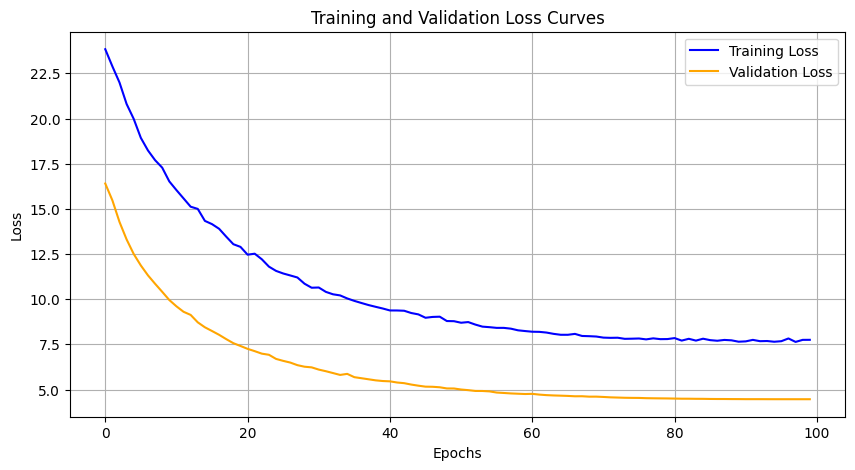

In [ ]:
import matplotlib.pyplot as plt
def plot_loss_curves(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='orange')
    plt.title('Training and Validation Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

plot_loss_curves(train_losses, val_losses)

In [ ]:
# Choose a random example from the validation dataset
example_index = np.random.randint(0, len(X_val))
past_traj = X_val[example_index]
future_traj = y_val[example_index]

# Get the predicted future trajectory
with torch.no_grad():
  model.eval()
  predicted_future = model(torch.tensor(past_traj[np.newaxis, :, :], dtype=torch.float32))
  predicted_future = predicted_future.numpy()[0]

past_traj[:, :2]

array([[ 0.        ,  0.        ],
       [ 0.17120361,  0.51983643],
       [ 0.34103394,  1.03363037],
       [ 0.50680542,  1.54278564],
       [ 0.67245483,  2.04858398],
       [ 0.83850098,  2.54876709],
       [ 1.00033569,  3.04656982],
       [ 1.16262817,  3.53881836],
       [ 1.32131958,  4.02685547],
       [ 1.48233032,  4.51330566],
       [ 1.64019775,  4.99737549],
       [ 1.79602051,  5.47570801],
       [ 1.95098877,  5.94940186],
       [ 2.10610962,  6.42016602],
       [ 2.25891113,  6.88806152],
       [ 2.41119385,  7.35345459],
       [ 2.56158447,  7.81549072],
       [ 2.71066284,  8.27410889],
       [ 2.85949707,  8.72912598],
       [ 3.00588989,  9.18109131],
       [ 3.15332031,  9.62713623],
       [ 3.29592896, 10.07019043],
       [ 3.44021606, 10.5100708 ],
       [ 3.58233643, 10.94482422],
       [ 3.72354126, 11.37518311],
       [ 3.86434937, 11.80175781],
       [ 4.00213623, 12.22375488],
       [ 4.14105225, 12.64282227],
       [ 4.27658081,

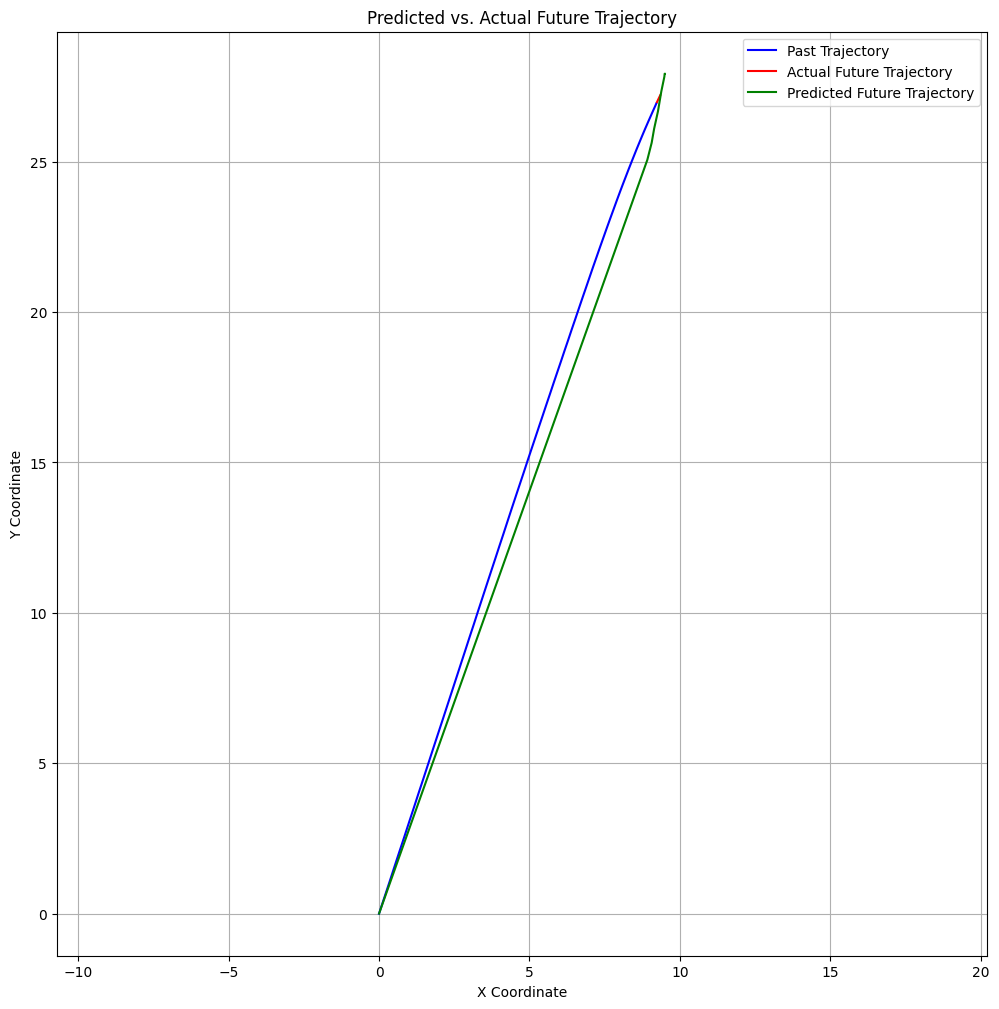

In [ ]:
# Plot the past trajectory, actual future trajectory, and predicted future trajectory
plt.figure(figsize=(12, 12))
plt.plot(past_traj[:, 0], past_traj[:, 1], label='Past Trajectory', color='blue')
plt.plot(future_traj[:, 0], future_traj[:, 1], label='Actual Future Trajectory', color='red')
plt.plot(predicted_future[:, 0], predicted_future[:, 1], label='Predicted Future Trajectory', color='green')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Predicted vs. Actual Future Trajectory')
plt.axis('equal')
plt.legend()
plt.grid()
plt.show()